In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

#plt.rcParams['image.interpolation'] = 'none'
#plt.rcParams['figure.figsize'] = (16, 10)

### amending below code to get sky subtraction seperate from 1d extraction for target

In [3]:
#defining some  functions to do things to the data from target
########'''  
    
def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
#using#def _linfit(model, x, y):
    # used inside subtract_sky to fit a linear model to the sky, which is
    # much faster

    #x = np.array(x, copy=False)
    #y = np.array(y, copy=False)

    #xb = np.mean(x)
    #yb = np.mean(y)
    #slope = (np.mean(x * y) - xb * yb) / (np.mean(x**2) - xb**2)
    #intercept = yb - slope * xb
    #return model.__class__(slope=slope, intercept=intercept)
    else:
        print ("Model type or polynomial degree not recognized")
    
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


  



def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)

            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0

            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self

        if kwargs.pop('transpose'):
            d = d.T

        res = plt.imshow(d, **kwargs)
        return res
    
    
    
#    plt.subplot(211)
#    plt.title('2D spec - Verify skyaps for correct target extraction')
#    if header['IRAFNAME']=='FeAr.spec': #blueside
#        print('choose 2D spec for blueside')
#        subimg.show_image(transpose=True,vmax=vmax,vmin=vmin) #replace as vmax=40,vmin=-10 if this doesnt work out well
#    elif header['IRAFNAME']=='henear.spec': #redside
#        print('choose 2D spec for redside')
#        subimg.show_image(transpose=False,vmax=vmax,vmin=vmin) #also replace here if doesnt work
#    else:
#        print("camera side for 2D spec not understood based on:",header['IRAFNAME'])
        #raise ValueError("Can't determine camera side ")    
    
 
    #setting up 1D extraction of target
    #setting up extraction range based on sky apps not sure if these is good to do b/c depends on extension of gal size
    ##begin = (skyaps[0][0] + 60)
    ##print ('this is beginning value of target spec extraction:',begin)
    ##end = (skyaps[1][0] - 30)
    ##print('this is end value of target spec extraction:',end)
    ##flux, unc = subimg.extract_spectrum((begin,end))



    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    

    
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#plt.subplot(212)
#plt.plot(comb.data[1])
#plt.plot(subimg(newdata))

## somewhere around here should be applying ds

In [4]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on
flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'


#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)
    
header = atlasfiles[0].header    


    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))


/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5


In [5]:
#stacking all those files of data from specific target-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

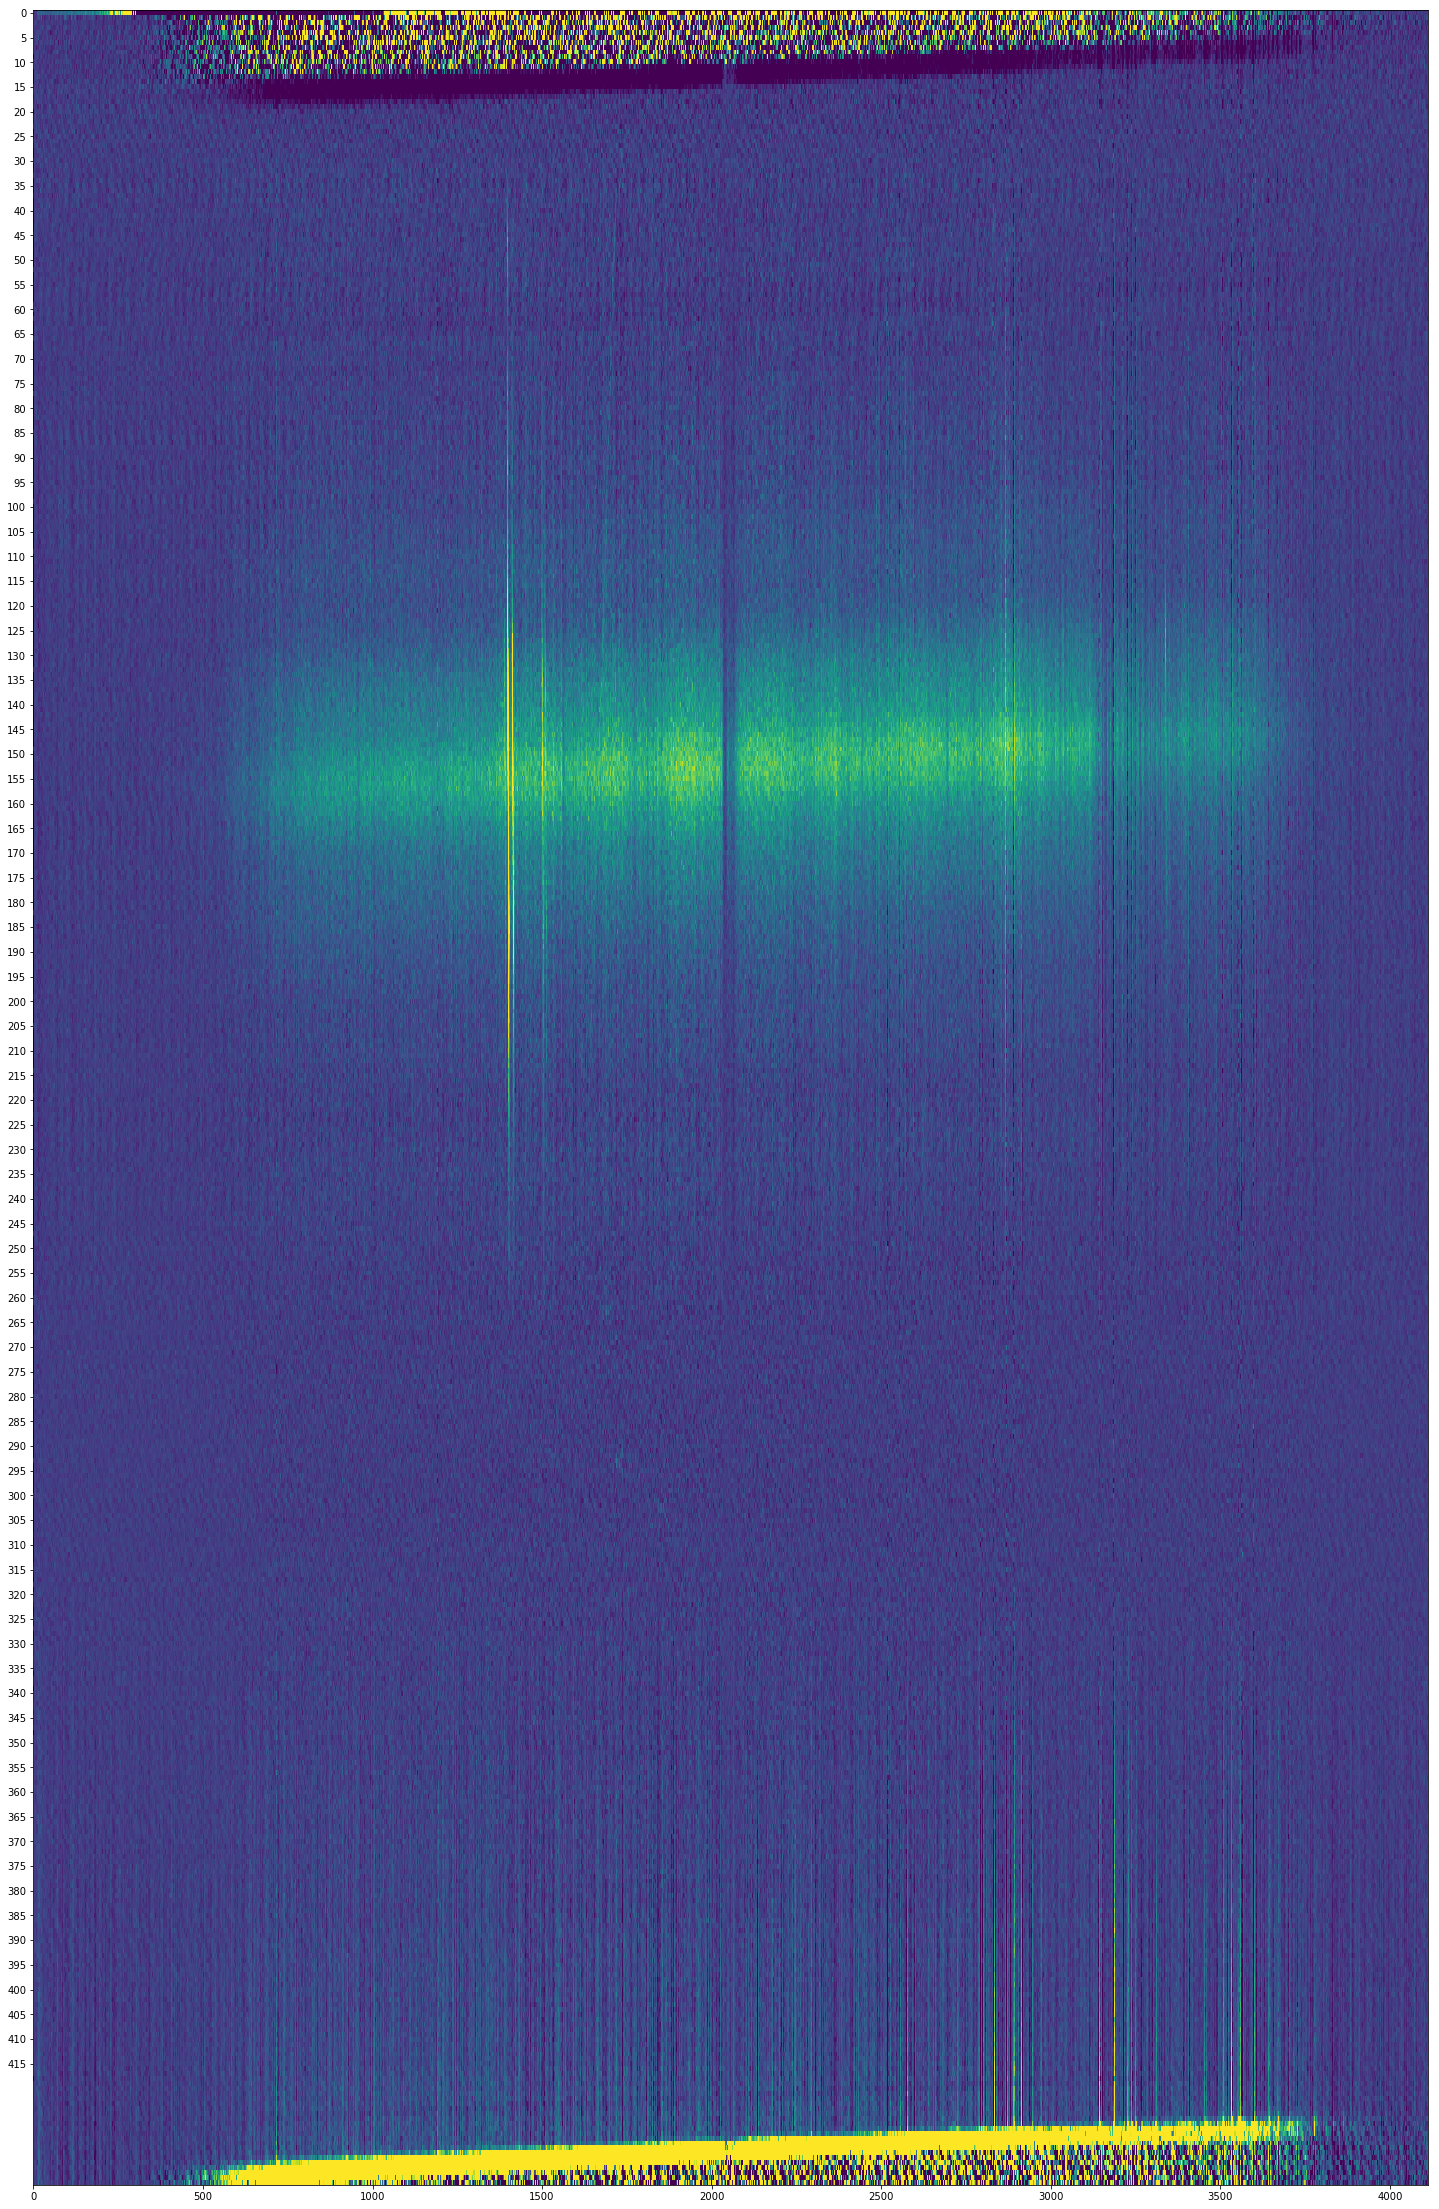

In [6]:
#first: want to see this newly cleaned 2d data visually
mydata=subimg2.data
vmin=-10
vmax=45
plt.figure(figsize=(25,40))

#instead of show_image function at top, doing this to show subtracted image

import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
plt.yticks(np.arange(0,420,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

In [7]:
#second: now want to see newly cleaned data in numbers
print(subimg2.data[::][0])

[ -6.35448395e+01   6.67014764e+01  -8.01993183e+02 ...,  -1.46522451e-01
  -3.74183006e-01  -1.10346141e+00]


In [8]:
#third: still exploring newly cleaned 2d data's format
subimg2.header
subimg2.data # flux is horiz.rows, wl is vertical columns

array([[ -6.35448395e+01,   6.67014764e+01,  -8.01993183e+02, ...,
         -1.46522451e-01,  -3.74183006e-01,  -1.10346141e+00],
       [ -6.56337357e+01,   6.85343634e+01,  -7.90691730e+02, ...,
          1.70647291e+00,   1.98860936e+00,   4.23329582e+00],
       [ -5.51667099e+01,   5.67780002e+01,  -7.71579219e+02, ...,
         -2.78473796e+00,  -4.65703081e+00,   7.35373758e-01],
       ..., 
       [ -5.85333640e+02,   4.28705913e+02,  -2.65243480e+03, ...,
          9.92516961e+00,   6.84470260e+00,  -4.45980143e+00],
       [ -7.38228216e+02,   4.29337799e+02,  -2.68054492e+03, ...,
          2.36865255e+00,  -5.99797231e+00,   8.07396868e+00],
       [ -7.28277178e+02,   4.07482835e+02,  -2.72690625e+03, ...,
          3.02872143e+00,  -2.94687367e+00,   1.84332008e+00]])

In [9]:
#still doing 'third' above
np.shape(comb2.data)

(440, 4114)

In [10]:
#still doing 'third' above
subimg2.data
#comb2

array([[ -6.35448395e+01,   6.67014764e+01,  -8.01993183e+02, ...,
         -1.46522451e-01,  -3.74183006e-01,  -1.10346141e+00],
       [ -6.56337357e+01,   6.85343634e+01,  -7.90691730e+02, ...,
          1.70647291e+00,   1.98860936e+00,   4.23329582e+00],
       [ -5.51667099e+01,   5.67780002e+01,  -7.71579219e+02, ...,
         -2.78473796e+00,  -4.65703081e+00,   7.35373758e-01],
       ..., 
       [ -5.85333640e+02,   4.28705913e+02,  -2.65243480e+03, ...,
          9.92516961e+00,   6.84470260e+00,  -4.45980143e+00],
       [ -7.38228216e+02,   4.29337799e+02,  -2.68054492e+03, ...,
          2.36865255e+00,  -5.99797231e+00,   8.07396868e+00],
       [ -7.28277178e+02,   4.07482835e+02,  -2.72690625e+03, ...,
          3.02872143e+00,  -2.94687367e+00,   1.84332008e+00]])

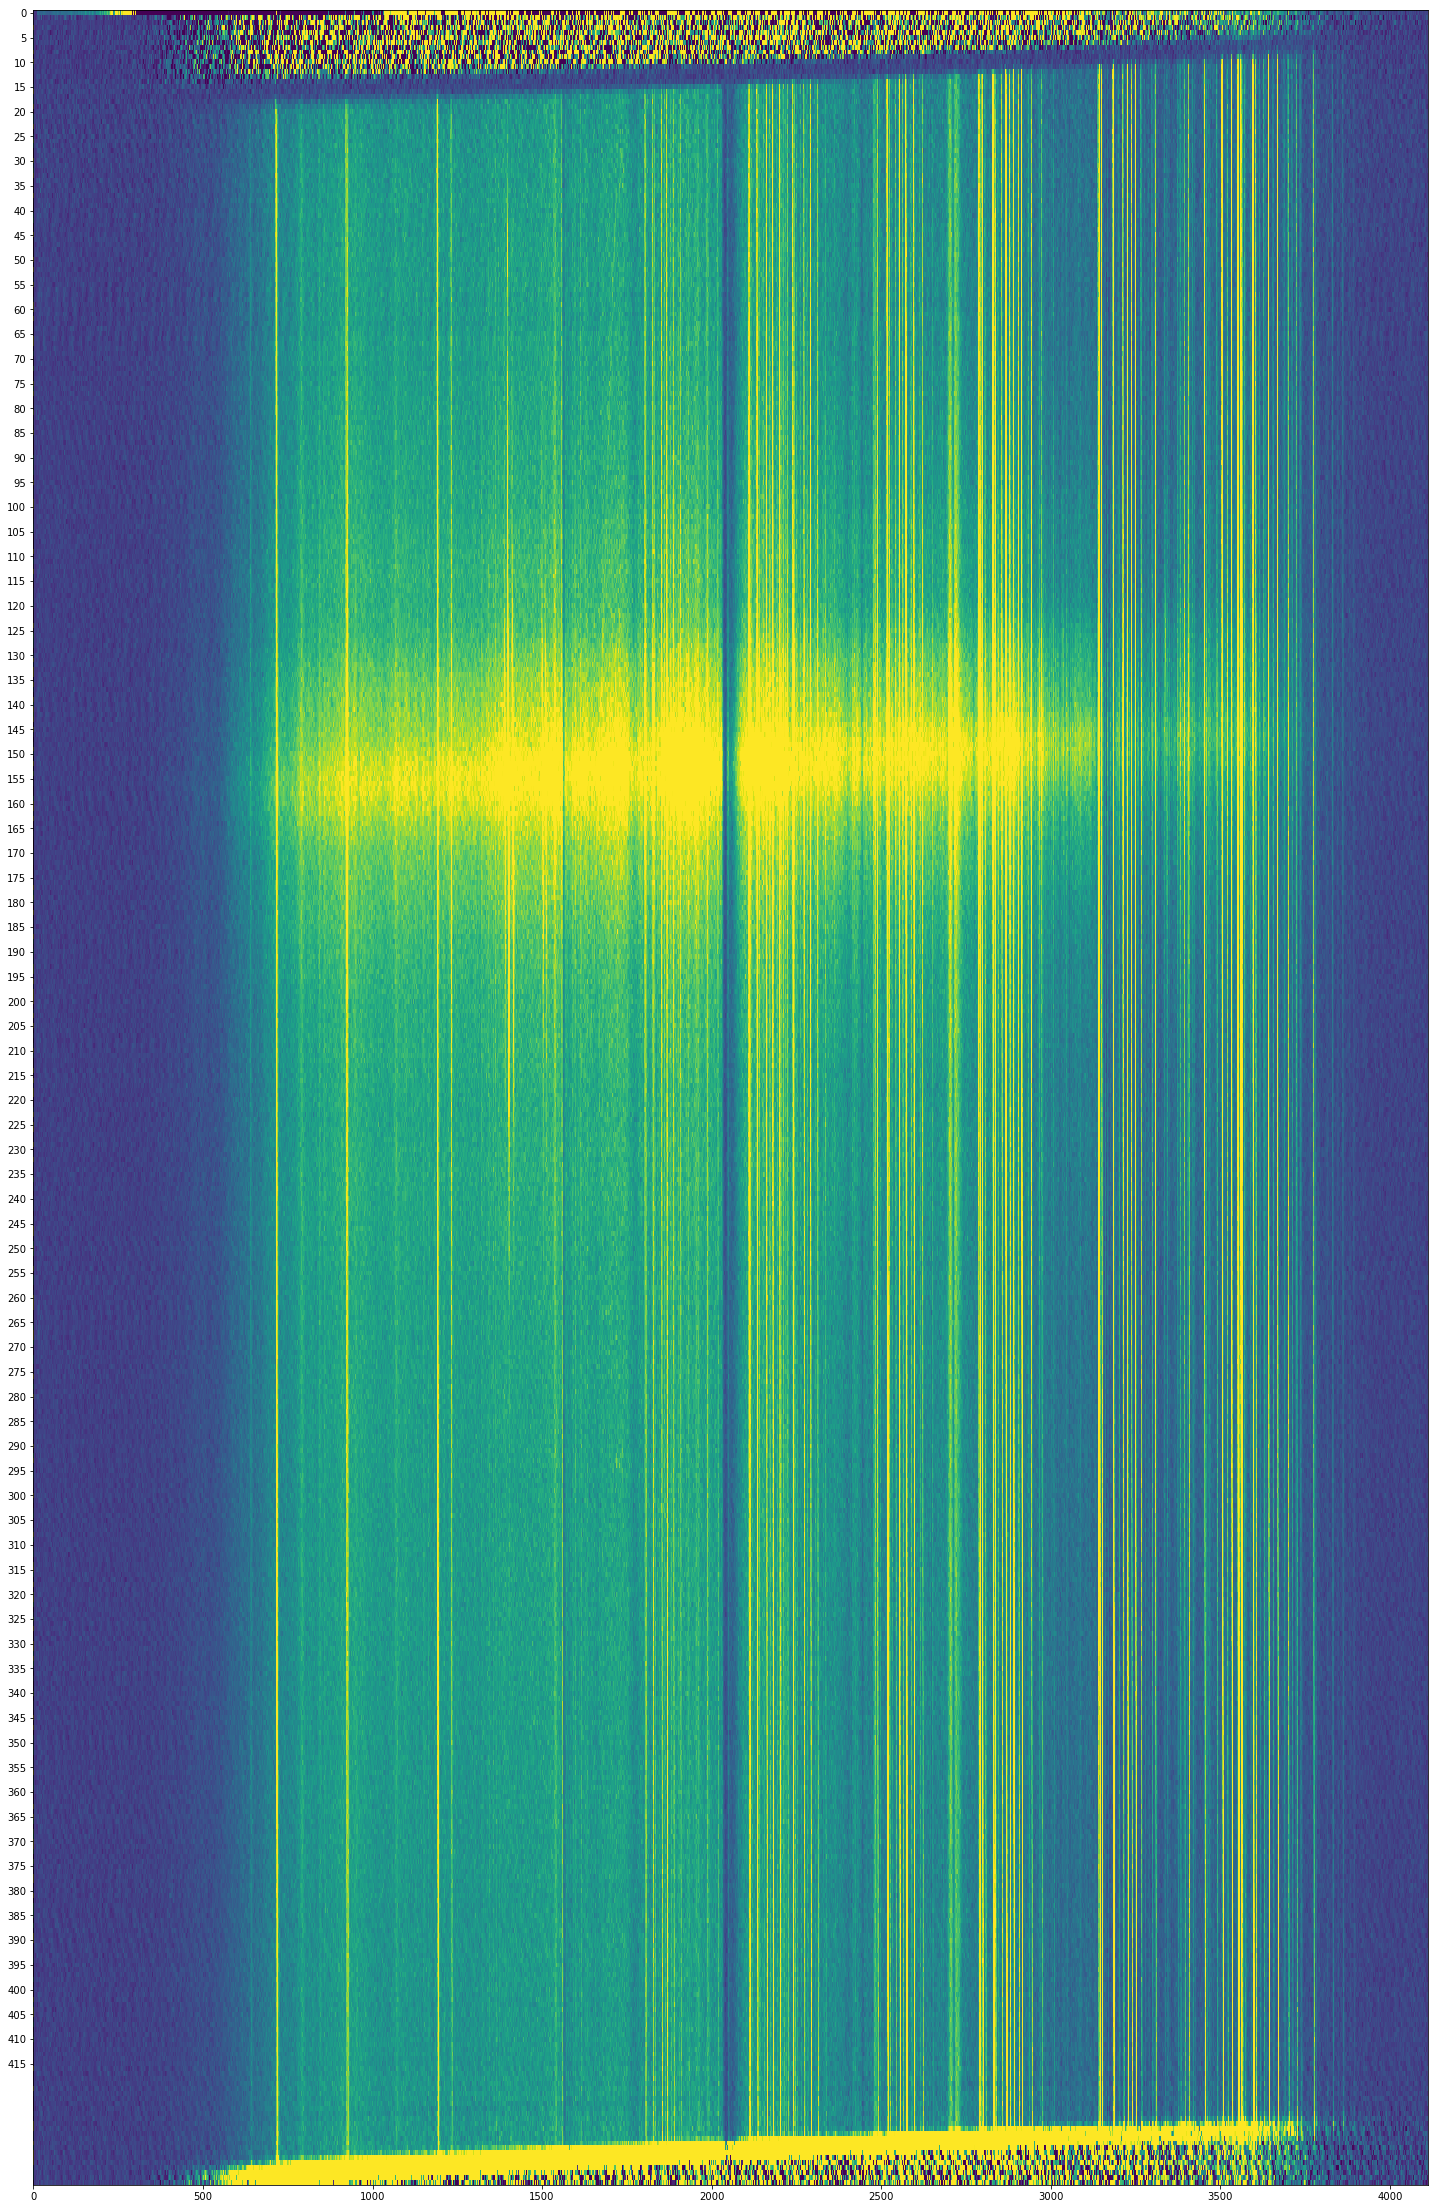

In [11]:
#fourth: want to see the un-skysubtracted data (but still instrument noise subtracted and stacked)
mydata=comb2.data #original stacked data
vmin=-10
vmax=45
plt.figure(figsize=(25,40))

plt.yticks(np.arange(0,420,5))
plt.imshow(mydata,aspect='auto',interpolation='nearest',vmin=vmin,vmax=vmax)

In [12]:
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way

        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis

        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)

        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')

        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5

        return spec, unc #spec-1D spectrum for target
#spec is summed data for each pixel column/wl within the spec aps range

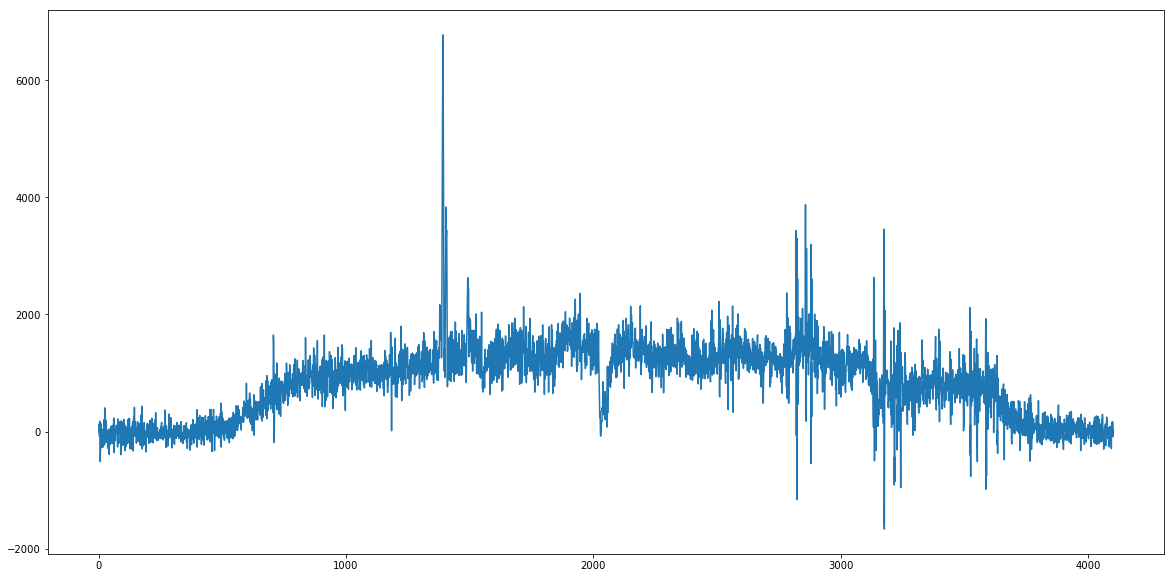

In [13]:
#getting 1D total spec for target-red side only tho!
#skipping applying dispersion solution b/c irrelevant to this type of test/can do at end

specaps=(35,260)
tspec_1d, unc = extract_spectrum('red',subimg2,specaps)
#tspec_1d is the total 1d spectrum for the galaxy on the right side of dblspec, pixel units still
#maybe should apply ds here??

tspec_1d=tspec_1d[10::] #cutting off fringe edges of detector
plt.figure(figsize=(20,10))
plt.plot(tspec_1d) #this is entire 1D spec summed thru full specaps range
#tspec_1d is red side 1d spec for target

In [14]:
#skip this BUT gives halpha location estimate to compare with centroid method below
#trying to find max flux (halpha presumably) and its wl still in pixel scale tho
#doing this on total red side 1d


np.shape(tspec_1d) #(4104,)
tspec_1d_wl= np.arange(0,len(tspec_1d),1)
data = Table([tspec_1d,tspec_1d_wl],names=('flux','wl'))
a=np.where(data['flux']==np.max(data['flux']))
c=data[a]
c

<Table length=1>
     flux       wl 
   float64    int64
------------- -----
6769.42669983  1392

### need to finish finding halpha via centriod search

In [15]:
#finding Halpha via centroid search.....maybe need to isolate wl range to just around emissionline
import astropy

tspec_1d = np.array(tspec_1d) #try making this a table, b/c right now its not a 2d array

from photutils import centroid_1dg
#x2, y2 = centroid_1dg(tspec_1d)
print((x2, y2))    

NameError: name 'x2' is not defined

# Different reduction method for mass profiles
### Going back to sky-subt. 2d stacked data to extract rotation curves

this is a good pixel range in spectral direction to isolate halpha for this target - may need to generalize more for others


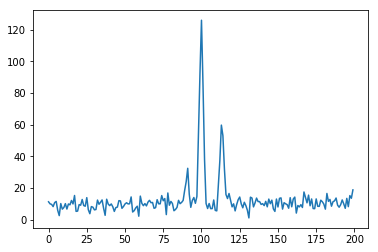

In [16]:
#exploring sky subtracted 2d spec data

#getting a halpha spatial range for one row of the data
plt.plot(subimg2.data[130][1300:1500])
print('this is a good pixel range in spectral direction to isolate halpha for this target - may need to generalize more for others')


FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE, NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)


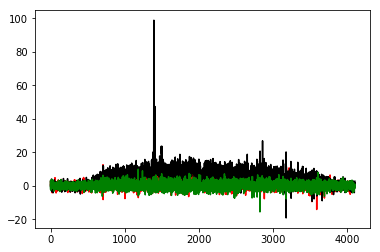

In [17]:
#first need to get spectrum for each spaitial pixel row



#new way

#extracting target spec from whole 2d spec
#specaps=(35,260)
aperature=(35,260) #target location
flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(aperature[0],aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE, NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 
##print('this is flux data shape:',np.shape(flux_data)) #(226, 4104)
##print('this is the flux data:',flux_data)
#spec = spec[10::]
plt.plot(flux_data[45],color='r')#near galaxy edge
plt.plot(flux_data[145],color='k') #near galaxy center
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)


In [18]:
#OLD WAY
#extracts a 1D target spec for each spatial row...summing along the way so it can be radii


#THIS MUST CHANGE TO JUST ADD EACH ROW....THEN SUM ROWS IF NEEDED

''' 

#specaps=(35,260)
aperature=(35,260)
flux_data=[]
apslc = np.arange(aperature[0],aperature[1]+1,1)
#print (apslc) #as expected, +1 so doesnt cut off last value
for i in apslc:
    spec = np.sum(subimg2.data[aperature[0]:i], axis=0)
    spec = spec[10::] #chops first 10 flux values in spectral direction-crazy osscillations
    flux_data.append(spec)
    
#need to find a way to sum over diff ranges of apslc 
print('this is flux data shape:',np.shape(flux_data))
#print('this is the flux data:',flux_data)
#spec = spec[10::]
plt.plot(flux_data[45],color='r')
plt.plot(flux_data[145],color='k')
plt.plot(flux_data[225],color='g')

'''


" \n\n#specaps=(35,260)\naperature=(35,260)\nflux_data=[]\napslc = np.arange(aperature[0],aperature[1]+1,1)\n#print (apslc) #as expected, +1 so doesnt cut off last value\nfor i in apslc:\n    spec = np.sum(subimg2.data[aperature[0]:i], axis=0)\n    spec = spec[10::] #chops first 10 flux values in spectral direction-crazy osscillations\n    flux_data.append(spec)\n    \n#need to find a way to sum over diff ranges of apslc \nprint('this is flux data shape:',np.shape(flux_data))\n#print('this is the flux data:',flux_data)\n#spec = spec[10::]\nplt.plot(flux_data[45],color='r')\nplt.plot(flux_data[145],color='k')\nplt.plot(flux_data[225],color='g')\n\n"

In [19]:
#this is to isolate galaxy core as the zero point by seperating the fluxes above and below core
#may not be necessary tho

#np.max(flux_data)#6769.4266998279936
#len(apslc)/2 #113 #this is center of target flux ie galaxy core WARNING --
#WARNING -- galaxy core needith be exactly at the center, should be more robust and 
#do a max search to id the core when refining code 


tspec_range=np.arange(0,len(flux_data),1)
spatially_below_core=[]
spatially_above_core=[]
for i in tspec_range:
    if i <= 112:
        spatially_below_core.append(flux_data[i])
    else:
        #print(i)
        spatially_above_core.append(flux_data[i])

#np.shape(flux_data[112::])      
        
len(spatially_above_core)#113
len(spatially_below_core)#113
#len(tspec_range)#226

113

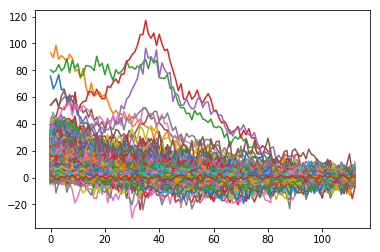

In [20]:
#testing

#np.shape(spatially_above_core) #(113, 4104)
np.max(spatially_above_core[0::])
plt.plot(spatially_above_core); #interesting............

In [21]:
#skip this should be using centroid after isolating around wl range
#test to find wl of max ie halpha


#np.shape(spatially_above_core)#(113, 4104) (spatial row above core(ie radius), wl)
m=np.max(spatially_above_core[1]) #chosing location close to core for accuracy of halpha zero pt location 
#before it moves with the limbs


#this will find the wl of the max value....in this case wl of max is halpha
#halpha_data=[]

for i, j in enumerate(spatially_above_core[1]):
    if j == np.max(spatially_above_core[1]):
        halpha = i
        #halpha_data.append(halpha)
#print(halpha_data)
        print('halpha spatial location ("wl") value (taken from spatial row 1 pixel above core):',halpha)
#NOTE this isnt real wl in angstroms, i havent applied ds to this test to get script right
print('m:',m)
#spatially_above_core[5][1390]

halpha spatial location ("wl") value (taken from spatial row 1 pixel above core): 1391
m: 89.4046887545


In [22]:
#isolating around wl range

#plt.plot(spatially_above_core[1]) #1 near core, 113 near edge
#print('max', np.max(spatially_above_core[1])) #gives flux not wl -- wl is ~ 1250 tho
spatially_above_core = np.array(spatially_above_core)
spatially_below_core = np.array(spatially_below_core)
#flux_data already array


#doing this for target spec seperated into above & below
halpha_range_above = spatially_above_core[:,1300:1500] #using pixel range good for this target
#print(np.shape(spatially_above_core)) #(113, 4104)
##myarray = np.array(spatially_above_core)
##print(np.shape(myarray[:,1300:1500])) #yes this is correct (113,200)
#print(np.shape(halpha_range_above)) #yes this is correct (113,200)
print('halpha_range_above is now the spectra above core for each spatial row only within spectral range surrounding halpha - good for centroiding now')
halpha_range_below = spatially_below_core[:,1300:1500] #using pixel range good for this target
#print(np.shape(halpha_range_below)) #yes this is correct (113,200)

#doing this for entire target spec
halpha_totalgalaxy = flux_data[:,1300:1500]
print(np.shape(halpha_totalgalaxy)) #yes this is correct (226,200)
print('THIS CELL HAS HALPHA ISOLATED SPEC DATAS TO USE THROUGHOUT!!!!!!!!!!!!!!!!!!!!!!!!!!')


#print(spatially_above_core) #113 arrays of data, each 4104 in length
#plt.plot(halpha_range_above)

halpha_range_above is now the spectra above core for each spatial row only within spectral range surrounding halpha - good for centroiding now
(226, 200)
THIS CELL HAS HALPHA ISOLATED SPEC DATAS TO USE THROUGHOUT!!!!!!!!!!!!!!!!!!!!!!!!!!


In [23]:
#testing for above cell
mylist = [np.linspace(0,9,10), np.linspace(20,29,10), np.linspace(10,19,10),np.linspace(10,19,10)]
#print(mylist)
mytest=np.array(mylist)
#a=mytest[::]
#print(a[1][1])
#print('a',a)

# LEFT OFF HERE!!! trying centroid

mytest: [[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.]
 [ 20.  21.  22.  23.  24.  25.  26.  27.  28.  29.]
 [ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.]
 [ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.]]
shape of mytest: (4, 10)
sub: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
x,y: (242.80185817712203, 1.6996823744316263)
just not sure what this output is. how is 242 the center of anything? looks more like a sum
WAIT, NEEDS TO BE CENTERED AROUND ZERO TO WORK - MAYBE?


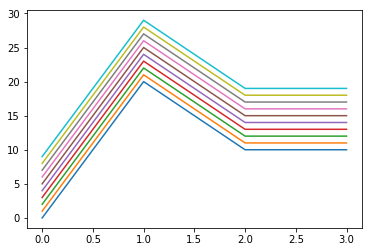

In [24]:
#testing how centroid works
#after isolating wl range need to use centroid to find halpha

print('mytest:',mytest)
#data = myarray()[::]
centroids=[]
#for i in a:

from photutils import centroid_1dg
print('shape of mytest:',np.shape(mytest))
print('sub:',mytest[0])
#x1, y1 = centroid_1dg(mytest[0]) #gives tuple index out of range error

x2, y2 = centroid_1dg(mytest) #main line of test
print('x,y:',(x2, y2)) 
print('just not sure what this output is. how is 242 the center of anything? looks more like a sum')
print('WAIT, NEEDS TO BE CENTERED AROUND ZERO TO WORK - MAYBE?')
#print('sub x1,y1:', (x1,y1))
plt.plot(mytest);
#plt.plot(x2,y2,'.',markersize=10) #see! this isnt the center

shape (226, 200)
okay so this is the core of the galaxy? center: 104.717740336 119.074471966


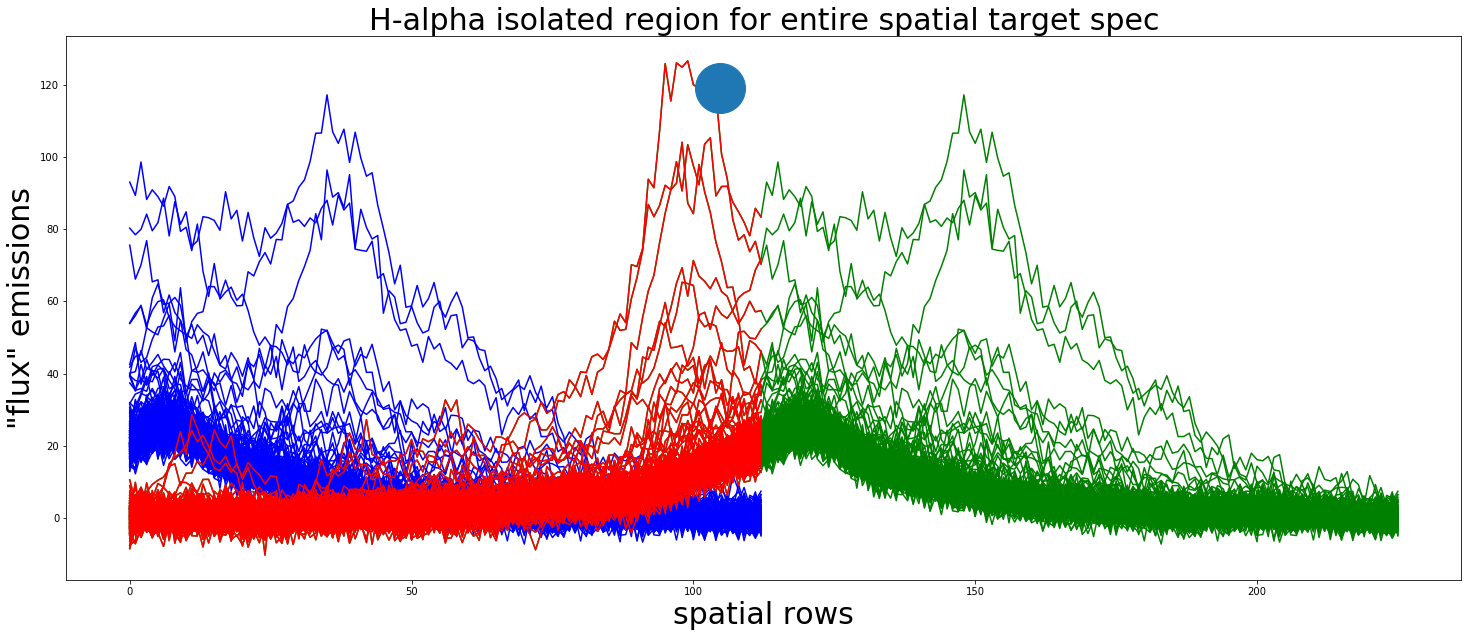

In [25]:
#trying centroid on real data
centroids_totalgalaxy = []
#for i in spatialrowlist: #create this as a way to do centroids for each row, y=row data, x=spatialrowlist
print('shape',np.shape(halpha_totalgalaxy))

x3, y3 = centroid_1dg(halpha_totalgalaxy) #main line of test
#print('x,y:',(x3, y3))

plt.figure(figsize=(25,10))


plt.plot(halpha_totalgalaxy,color='g');
plt.plot(halpha_range_above,color='b');
plt.plot(halpha_range_below,color='r');
plt.plot(x3,y3,'.',markersize=100)
plt.xlabel('spatial rows',fontsize=30)
plt.ylabel('"flux" emissions',fontsize=30)
plt.title('H-alpha isolated region for entire spatial target spec',fontsize=30)

print('okay so this is the core of the galaxy?','center:',x3,y3)

In [26]:
#testing to fix above tuple problem
from photutils.datasets import make_4gaussians_image
data = make_4gaussians_image()[43:79, 76:104] #this is really just 36 arrays of 28 random numbers
#data is like mytest 
print(np.shape(data)) #36,28
print(data[0]) #1st array of 28 values

(36, 28)
[  6.30586689  14.64518886  12.85808267  10.32359301  21.09191642
   4.87643308  17.45390734  22.39472756  14.52554921  20.68247539
   7.5563963   13.76273054  16.54028649  22.04400638  17.43250842
   4.88009076   8.03625949  16.52389304  16.9075967    9.48969808
   2.84423487   9.30709683  -4.54989079  10.98954184   8.10826991
   2.93520674   3.14233696   2.60783719]


In [27]:
#from laura

#try this test data set instead - needs to be more gaussian
x = np.linspace(0,10,11)
y = np.linspace(0,10,11)
xx,yy = np.meshgrid(x,y)
#test = norm.pdf(xx, 4, 2) * norm.pdf(yy, 6, 2)
#do above line after figureing out what norm is

# Below has Problems

shape arr2d: (1, 226)
newshape (452,)


TypeError: Improper input: N=4 must not exceed M=1

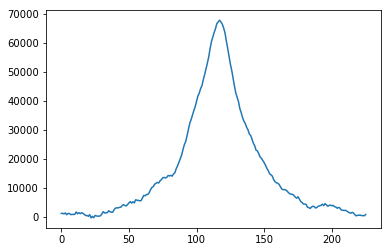

In [128]:
#finding core via centroid
#collasping along spectral direction

np.shape(flux_data) #226,4104
np.shape(np.sum(flux_data,axis=1)) #good, only want one wl, keep all 226 spatial rows
arr = np.sum(flux_data,axis=1) #explicitly making an array
arr2d = arr[:, np.newaxis] #needs to be 2d array for centroiding
print('shape arr2d:',np.shape(arr2d.T))#226,1
plt.plot(arr2d)#this looks promising


#trying to inject a 2nd array of all ones for weight values since new axis gave error
ones = np.ones(len(arr))
#ones = [ones]
#arr = [arr]
#print('ones',np.shape(ones))#good
#arr_list=[]
#arr_list.append(ones)
#arr_list.append(arr)
#print(np.shape(arr_list)) #heres the problem
#arr_list = np.reshape(226,226)




#another ones attempt
testing = np.append(arr,ones,axis=0)
#testing = np.reshape(226,226) #still wont work
print('newshape',np.shape(testing))


#new axis method but below give errors
#length = np.linspace(0,len(arr))
#len(length)
#arr2d_test = np.array[arr, length] #there should be a line to make 1d into 2d, b/c this dont work



#tried arr2d & arr2d.T, same error
x4, y4 = centroid_1dg(arr2d.T) #gives errors, unsure why
plt.plot(x4,y4,'.',markersize=10)



### problem trying to isolate halpha peak...some rows are noisy so peak isnt halpha....why?? --- b/c those noisy rows are too far from galaxy so bad s/n, expect to see farther from core, but isolate wl range to help

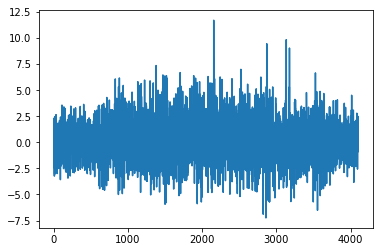

In [28]:
#testing

mylist = [1,2,3,4,5,6,7]
mylist[4:5]
mylist[4]
#for i, j in enumerate(spatially_above_core[5]):
#    print('this is i:',i) #array number
#    print('this is j:',j)#flux value
plt.plot(spatially_above_core[112]) #this is a problem....B/C AT EDGE OF GALAXY - LOW S/N!!!!!

ask erik about below interpretation
above and below plots show 0 is farthest from core, 112 pixel row is at the core?(b/c noiser-everywhere equally bright)
nope its opposite, good spec is at core[0], bad spec is near edge(112)


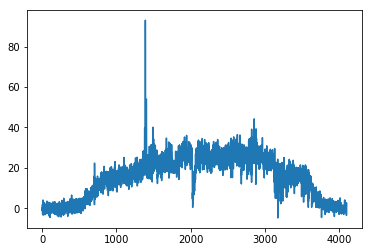

In [29]:
#testing
plt.plot(spatially_above_core[0]) #this is near core, good s/n
print('ask erik about below interpretation')
print('above and below plots show 0 is farthest from core, 112 pixel row is at the core?(b/c noiser-everywhere equally bright)')
print('nope its opposite, good spec is at core[0], bad spec is near edge(112)')

In [30]:
#skip - do diff method
#isolating halpha emissions in each spatial row

halpha_above=[]
halpha_below=[]
pixelrange=np.arange(0,113,1)
for k in pixelrange:
    #idk=np.sum(spatially_above_core[i][1391:1392])#isolating halpha
    #halpha_max=np.max(spatially_above_core[k])
    for i, j in enumerate(spatially_above_core[k]): #for each pixel row data is (wl,flux value)
        if j == np.max(spatially_above_core[k]): #max flux
            halpha_wl = i
            halpha_above.append(halpha_wl)
print(halpha_above,'problem is the max for each row isnt always halpha ')
    #halpha_above.append(idk)
    #idk2 = np.sum(spatially_below_core[i][1391:1392])#somehow need to generalize wl ranges to add...seek out max..
    #halpha_below.append(idk2)
    
np.shape(halpha_above)#113 spatial rows of halpha flux

[1391, 1391, 1391, 1391, 1391, 1391, 1392, 1391, 1391, 1392, 1392, 1392, 1391, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1392, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1393, 1394, 1393, 1393, 1393, 1393, 1393, 1393, 1394, 1394, 1393, 1393, 1394, 1393, 1393, 1393, 1394, 1394, 1394, 1393, 1394, 1394, 1394, 1394, 1393, 1393, 3175, 1394, 1394, 1393, 1394, 2858, 3175, 3175, 1394, 3175, 3175, 3175, 3175, 3175, 3175, 3175, 3175, 3175, 1394, 3175, 3175, 1394, 3175, 1393, 3588, 1394, 1663, 1394, 2343, 3175, 3175, 1182, 2156] problem is the max for each row isnt always halpha 


(113,)

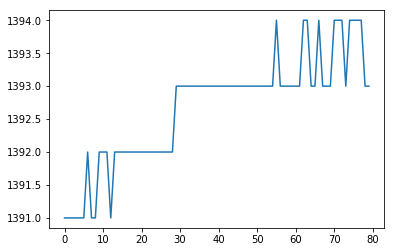

In [31]:
#testing plotting the halpha associated with above cell

#plt.plot(halpha_above)
#print('why is it going crazy in last few values??')

#chopping last few values to avoid crazy peaks that arent halpha ~roughly cutting 28
halpha_above_cut = halpha_above[0:80]
plt.plot(halpha_above_cut)
#still looking really odd.....why the oscillations? - maybe need to do ds....for real

# START HERE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [32]:
#test with newly defined above core spec PART ONE

halpha_above2=[]
halpha_below2=[]
pixelrange2=np.arange(0,113,1)
for k in pixelrange2:
    #idk=np.sum(spatially_above_core[i][1391:1392])#isolating halpha
    #halpha_max=np.max(spatially_above_core[k])
    for i, j in enumerate(halpha_range_above[k]): #for each pixel row data is (wl,flux value)
        if j == np.max(halpha_range_above[k]): #max flux
            halpha_wl2 = i
            halpha_above2.append(halpha_wl2)
    for i, j in enumerate(halpha_range_below[k]): #for each pixel row data is (wl,flux value)
        if j == np.max(halpha_range_below[k]): #max flux
            halpha_wl2 = i
            halpha_below2.append(halpha_wl2)
print(halpha_above2,'problem is the max for each row isnt always halpha ',halpha_below2)

[91, 91, 91, 91, 91, 91, 92, 91, 91, 92, 92, 92, 91, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 93, 93, 93, 93, 93, 93, 94, 94, 93, 93, 94, 93, 93, 93, 94, 94, 94, 93, 94, 94, 94, 94, 93, 93, 93, 94, 94, 93, 94, 94, 94, 94, 94, 94, 93, 93, 195, 107, 94, 95, 94, 107, 94, 94, 94, 94, 95, 93, 94, 94, 93, 94, 168, 95, 108, 198, 79] problem is the max for each row isnt always halpha  [145, 131, 103, 86, 89, 89, 89, 88, 89, 89, 88, 89, 89, 88, 88, 89, 89, 89, 89, 90, 89, 89, 89, 89, 89, 89, 89, 90, 89, 134, 90, 14, 151, 88, 89, 89, 90, 88, 89, 89, 89, 89, 89, 89, 89, 88, 89, 89, 88, 89, 89, 88, 89, 89, 89, 89, 89, 89, 89, 88, 89, 89, 89, 89, 89, 89, 89, 88, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 90, 90, 89, 89, 89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91]


TEST FAILED, CENTROID IS NECESSARY!!


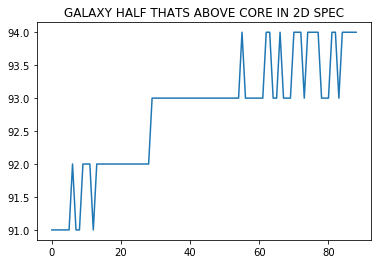

In [33]:
#test PART TWO
halpha_above2 = np.array(halpha_above2)
halpha_below2 = np.array(halpha_below2)
halpha_above_cut2 = halpha_above2[0:89]
plt.plot(halpha_above_cut2)
plt.title('GALAXY HALF THATS ABOVE CORE IN 2D SPEC')
print('TEST FAILED, CENTROID IS NECESSARY!!')

[145 131 103  86  89  89  89  88  89  89  88  89  89  88  88  89  89  89
  89  90  89  89  89  89  89  89  89  90  89 134  90  14 151  88  89  89
  90  88  89  89  89  89  89  89  89  88  89  89  88  89  89  88  89  89
  89  89  89  89  89  88  89  89  89  89  89  89  89  88  89  89  89  89
  89  89  89  89  89  89  90  90  89  89  89  89  89  89  89  90  90  90
  90  90  90  90  90  90  90  90  90  90  90  90  90  90  90  90  90  91
  91  91  91  91  91]
what is this??-true core??


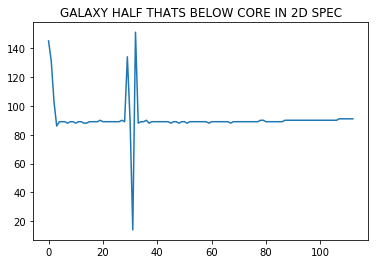

In [34]:
#test PART THREE
print(halpha_below2)
#print(halpha_below2.T)
#halpha_below_cut = halpha_below[0:89]
plt.plot(halpha_below2)
plt.title('GALAXY HALF THATS BELOW CORE IN 2D SPEC')


print('what is this??-true core??')

YUP NEED TO CENTROID, MAX ISNT GOOD ENOUGH


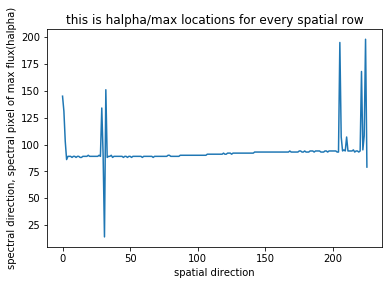

In [35]:
#test PART FOUR - end

halpha_totalgal=[]
pixelrange=np.arange(0,226,1)
for k in pixelrange:
    #idk=np.sum(spatially_above_core[i][1391:1392])#isolating halpha
    #halpha_max=np.max(spatially_above_core[k])
    for i, j in enumerate(halpha_totalgalaxy[k]): #for each pixel row data is (wl,flux value)
        if j == np.max(halpha_totalgalaxy[k]): #max flux
            halpha_wl = i
            halpha_totalgal.append(halpha_wl)
            
plt.title('this is halpha/max locations for every spatial row')
plt.plot(halpha_totalgal)
plt.xlabel('spatial direction')
plt.ylabel('spectral direction, spectral pixel of max flux(halpha)')


print('YUP NEED TO CENTROID, MAX ISNT GOOD ENOUGH')

this looks so much better - still not right but better, besides whats in title also need to make core the center and convert pix to wl
ha 155


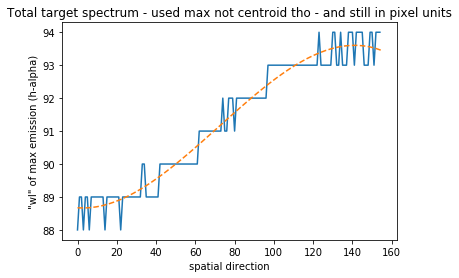

In [36]:
plt.plot(halpha_totalgal[45:200]) #region between oscill in above cell
plt.title('Total target spectrum - used max not centroid tho - and still in pixel units')
print('this looks so much better - still not right but better, besides whats in title also need to make core the center and convert pix to wl')

#fitting a line
testdata = halpha_totalgal[45:200]
xtest = np.linspace(0,len(testdata))
#x = np.array(np.linspace(0, testdata, 4))
xp = np.arange(0,len(halpha_totalgal[45:200]),1)
print('ha',len(halpha_totalgal[45:200]))
#print('xp:',len(xp))
poly = np.poly1d(np.polyfit(xp,halpha_totalgal[45:200], 3))
plt.xlabel('spatial direction')
plt.ylabel('"wl" of max emission (h-alpha)')
plt.plot(xtest,poly(xtest),'--')

In [ ]:
#lets apply that ds

# END HERE

In [37]:
#len(halpha_totalgal[::])#226
np.shape(halpha_totalgal)

(226,)

In [38]:
#need to reverse below side to get galaxy core as the origin

radiusrange = np.linspace(0,len(halpha_above))
radiusrange = np.array(radiusrange)
halpha_above = np.array(halpha_above)
print(radiusrange)
radius_above=[]
radius_below=[]
for i in radiusrange:
    sumr = np.sum(halpha_above[i,::]) #summing each row to the end
    radius_above.append(sumr)
    sumr2 = np.sum(halpha_above[i::])
    radius_below.append(sumr2)
    #list.reverse(radius_below)



#above isnt what i want...maybe this whole cell isnt necessary
np.shape(radius_below)

[   0.            2.30612245    4.6122449     6.91836735    9.2244898
   11.53061224   13.83673469   16.14285714   18.44897959   20.75510204
   23.06122449   25.36734694   27.67346939   29.97959184   32.28571429
   34.59183673   36.89795918   39.20408163   41.51020408   43.81632653
   46.12244898   48.42857143   50.73469388   53.04081633   55.34693878
   57.65306122   59.95918367   62.26530612   64.57142857   66.87755102
   69.18367347   71.48979592   73.79591837   76.10204082   78.40816327
   80.71428571   83.02040816   85.32653061   87.63265306   89.93877551
   92.24489796   94.55102041   96.85714286   99.16326531  101.46938776
  103.7755102   106.08163265  108.3877551   110.69387755  113.        ]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [39]:
#testing 
radius_below = np.array(radius_below)
type(radius_below)

numpy.ndarray

In [40]:
#trying to invert array so 
#that galaxy core is at center of graphs

radius_below = np.flip(radius_below,axis=0)
radius_below

array([], dtype=float64)

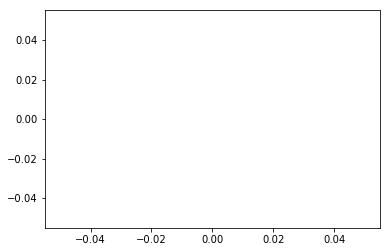

In [41]:
#do the pixel plate scale too!!!!!!!!!!!!!!!!!!!!!!!!!
#need to fix radiusrange way above

from astropy import units as u
r_in_arcmin = 1*u.arcmin# radial distance of measurement from centre of object in arcmin
distance = 5*u.Mpc # distance of object from us
r_in_kpc = (r_in_arcmin/u.rad*distance).to("kpc") # radial distance of measurement from centre of object in kpc

redplatescale = 0.293*u.arcsec/u.pixel
blueplatescale = 0.389*u.arcsec/u.pixel

dbsp_pix_equiv = u.pixel_scale(redplatescale)
r_in_pixel = 2*u.pixel
r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)

#testing if inverting array worked....kinda did except somethings still not right-see next cell
#b/c above and below use the same zero point but its not in center of them
#ie i get an X instead of a V that falls off at edges
plt.plot(radius_below)

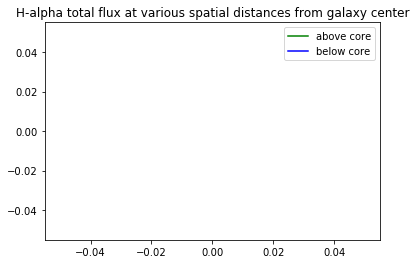

In [42]:
plt.title('H-alpha total flux at various spatial distances from galaxy center')
#plt.ylabel('flux-not calibrated')
#plt.xlabel('pixel distance from galaxy center - no ds applied yet')
above, = plt.plot(radius_above, color='g',label='above core')
below, = plt.plot(radius_below, color='b',label='below core')
plt.legend(handles=[above,below])


In [43]:
#whole cell of tests

#test if slices mean what i think they mean
aps = [1,3]

dt = ([[1,2,3],
     [4,5,6],
     [7,8,9],
    [10,11,12]])


aps = [1,3]

dt = ([[1,2,3],
     [4,5,6],
     [7,8,9],
    [10,11,12]])
aslice = np.arange(aps[0],aps[1]+1,1) #target spatial row numbers in an array #1,2,3
mydata=[] #empty list to collect outputs
for i in aslice: #doing stuff for each spatial row of the target
    #print(i)
    test = np.sum(dt[aps[0]:i], axis=0) #summing each spatial row of target
    mydata.append(test) #collecting all outputs


    ntest = np.sum(dt[2],axis=0)
mydata#so each of these arrays is a 1D spec out to total 
dt[1::]


#testing is sum axis is what i think
testing=np.sum([[0, 1], [0, 5]], axis=0)
testing

dt[aps[0]:1]#empty so first array of sums will always be zero but thats okay, just remember to cut it off
#dt[aps[0]] #4,5,6

[]

# END OF TEST

In [44]:
#len(comb.data) #440
#len(comb.data[0]) #4114
np.shape(comb.data) #(440,4114)

(440, 4114)

In [45]:
data_slice = comb.data[1][1999]
data_slice

25.824504017342026

In [46]:
data=comb.data
data

array([[ -8.11022338e-01,  -1.07129855e+00,  -1.29068135e+00, ...,
          9.59993461e-01,   9.63950343e-01,  -5.40156495e-02],
       [ -5.74223461e+00,   3.81096651e+00,  -5.39335075e+00, ...,
          2.80427601e+00,   3.33067000e+00,   5.28431249e+00],
       [  1.90260035e+00,  -4.91364753e+00,  -1.59477259e+00, ...,
         -1.69558546e+00,  -3.31108325e+00,   1.78794635e+00],
       ..., 
       [  1.52560364e+02,   1.40634585e+01,   8.70192376e+00, ...,
          1.31505721e+01,   6.05276324e+00,  -4.14973174e+00],
       [  5.61820787e+00,   1.00408333e+01,   4.60068676e+00, ...,
          5.61252744e+00,  -6.80362796e+00,   8.37906864e+00],
       [  2.15417900e+01,  -1.64862712e+01,  -1.76615644e+01, ...,
          6.29113097e+00,  -3.76628598e+00,   2.14343533e+00]])

In [47]:
data2=data.transpose()
data2#this is the struccture matrix i want aka each first array (larger) is column
#so that will match the sky emission columns

array([[ -8.11022338e-01,  -5.74223461e+00,   1.90260035e+00, ...,
          1.52560364e+02,   5.61820787e+00,   2.15417900e+01],
       [ -1.07129855e+00,   3.81096651e+00,  -4.91364753e+00, ...,
          1.40634585e+01,   1.00408333e+01,  -1.64862712e+01],
       [ -1.29068135e+00,  -5.39335075e+00,  -1.59477259e+00, ...,
          8.70192376e+00,   4.60068676e+00,  -1.76615644e+01],
       ..., 
       [  9.59993461e-01,   2.80427601e+00,  -1.69558546e+00, ...,
          1.31505721e+01,   5.61252744e+00,   6.29113097e+00],
       [  9.63950343e-01,   3.33067000e+00,  -3.31108325e+00, ...,
          6.05276324e+00,  -6.80362796e+00,  -3.76628598e+00],
       [ -5.40156495e-02,   5.28431249e+00,   1.78794635e+00, ...,
         -4.14973174e+00,   8.37906864e+00,   2.14343533e+00]])

In [48]:
#testing

test = ([[1,2,3,4,5],[6,7,8,9,0],[10,20,30,40,50]])
np.shape(test)

(3, 5)

In [49]:
#testing
test2=np.reshape(test,(5,3))
#test2
type(test2)

numpy.ndarray

In [50]:
#testing
test=np.array(test)
type(test)
test.transpose()

array([[ 1,  6, 10],
       [ 2,  7, 20],
       [ 3,  8, 30],
       [ 4,  9, 40],
       [ 5,  0, 50]])

In [51]:
#testing
test4=test[2:]
test4
#model_x = np.linspace(0, len(test4), len(test4)*10)
#plt.plot(model_x)

array([[10, 20, 30, 40, 50]])

In [52]:
data3=data2[2000] #this is around a sky line

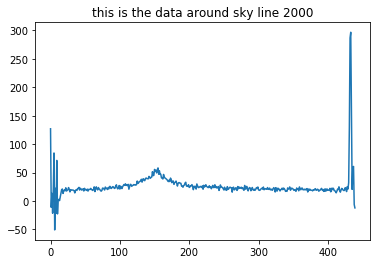

In [53]:
plt.plot(data3)
plt.title('this is the data around sky line 2000')

In [54]:
#model_x = np.linspace(0, len(data2), len(data2)*10)
#plt.plot(model_x)
mymodel= modeling.models.Polynomial1D(7)
#uses these vals from above skyaps=[(30,110),(180,400)] 
subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
#maybe=subimg
type(subimg)
#np.shape(subimg)

reduce_dblspec.DoubleSpecImage

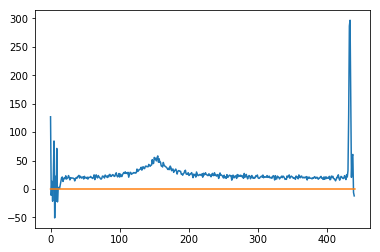

In [55]:
#model=np.array(subimg.data)
#plt.plot(model)
model_data=subimg.data.transpose()
#np.shape(model_data)
model_data2=model_data[2000] #isolating column along a sky emission, model fitted data
fitter = modeling.fitting.LevMarLSQFitter()
plt.plot(data3)
#type(model_data)
model_x = np.linspace(0, len(data3), len(data3)*10) #this has more points so need to go over data not with it
plt.plot(model_x,mymodel(model_x))

In [56]:
#mymodel(test)
np.shape(model_data2)

(440,)

In [57]:
modeling.models.Polynomial1D(7)(test)

array([[ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])

## TARGET: SD-2  
### SKY LINE 2000

model_x (440,)
new_model ()


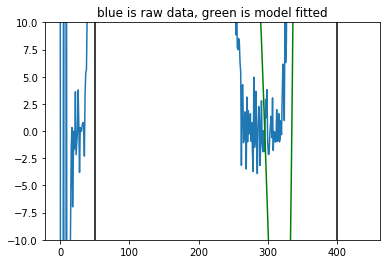

In [58]:
###SKY LINE
model_data2=model_data[2000] #isolating column along a sky emission, model fitted data

skyaps=[(30,110),(180,400)] #used from 5/19/17 night for sd-2
x = np.linspace(0, len(model_data2), len(model_data2)*10) #(4400,)
model_x = np.arange(0,len(model_data2))
y = model_data2
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(6)#, n_models=1)

#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x[50:400], y[50:400])#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
#plt.xticks(x)
plt.title('blue is raw data, green is model fitted')

plt.plot(model_x,y)#(model_x,y)
plt.plot(x,new_model(x),color='g')#(x,new_model(x),color='g')
plt.ylim(-10,10)
plt.axvline(50,color='k')
plt.axvline(400,color='k')

In [59]:
len(model_x)

440

In [60]:
p2

<Polynomial1D(6, c0=0.0, c1=0.0, c2=0.0, c3=0.0, c4=0.0, c5=0.0, c6=0.0)>

In [61]:
new_model

<Polynomial1D(6, c0=5592.246837941313, c1=-257.50458628617616, c2=4.42008868807051, c3=-0.03527549844823839, c4=0.00014339527975830297, c5=-2.8958505209189406e-07, c6=2.3109959279424218e-10)>

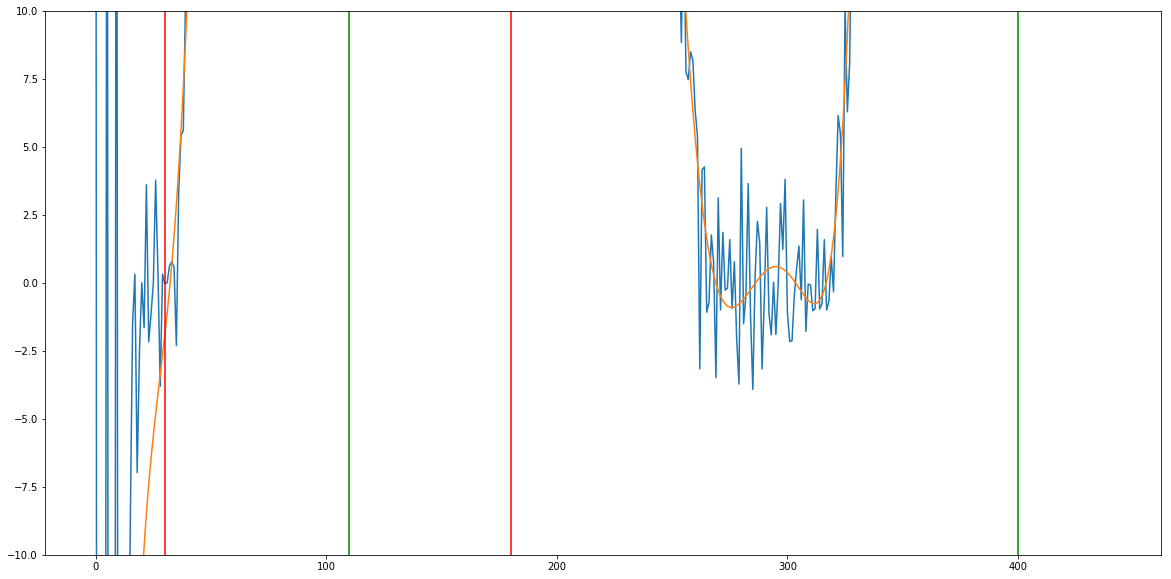

In [62]:
#from erik
p2 = modeling.models.Polynomial1D(9,c0=1)#, n_models=1)
plt.figure(figsize=(20,10))



data = model_data2  # from your notebook
x_data = np.arange(len(data))
x_model = np.linspace(0, len(data), 10*len(data))

xfits = []
yfits = []
for lower, upper in skyaps:
    xfits.append(x_data[lower:upper])
    yfits.append(data[lower:upper])
xfit = np.concatenate(xfits)
yfit = np.concatenate(yfits)
new_model = pfit(p2, xfit.astype(float), yfit)

plt.plot(x_data, data) # should be the same as plt.plot(data)
plt.plot(x_model, new_model(x_model))
plt.ylim(-10,10)
new_model
for lower,upper in skyaps:
    plt.axvline(lower,color='r')
    plt.axvline(upper,color='g')

In [63]:
#yfit

In [64]:
#x = np.linspace(0, len(model_data2), len(model_data2)*10) #(4400,)
#model_x = np.arange(0,len(model_data2))
#y = model_data2
#p2 = modeling.models.Polynomial1D(3)
#pfit = modeling.fitting.LevMarLSQFitter()

#new_model = pfit(p2, x, y)
#print(p2(y)) ## all zeros, this is the problem

#plt.plot(model_x,p2(y))

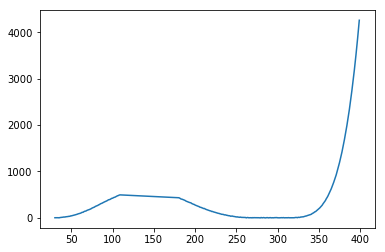

In [65]:
plt.plot(xfit,yfit)

In [66]:
x_model

array([  0.00000000e+00,   1.00022732e-01,   2.00045465e-01, ...,
         4.39799955e+02,   4.39899977e+02,   4.40000000e+02])

### DIFF SKY LINE 3173

model_x (440,)
new_model ()


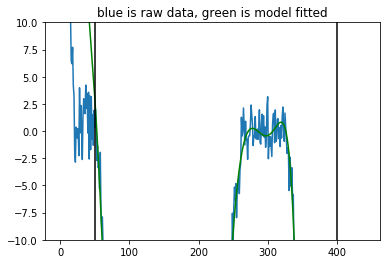

In [67]:
#checking diff sky line:


model_data3=model_data[3173]

skyaps=[(30,110),(180,400)] 
x = np.linspace(0, len(model_data3), len(model_data3)*10) #(4400,)
model_x = np.arange(0,len(model_data3))
y = model_data3
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(7)#, n_models=1)

#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x[50:400], y[50:400])#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
#plt.xticks(x)
plt.title('blue is raw data, green is model fitted')

plt.plot(model_x,y)#(model_x,y)
plt.plot(x,new_model(x),color='g')#(x,new_model(x),color='g')
plt.ylim(-10,10)
plt.axvline(50,color='k')
plt.axvline(400,color='k')

### NO SKY LINE

model_x (440,)


new_model ()


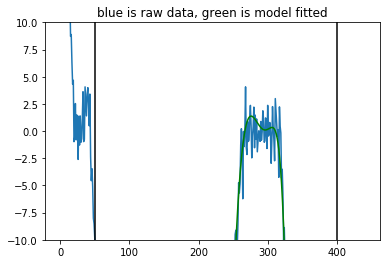

In [68]:
#checking a place with no sky emissions:

model_data4=model_data[3077]

skyaps=[(30,110),(180,400)] 
x = np.linspace(0, len(model_data4), len(model_data4)*10) #(4400,)
model_x = np.arange(0,len(model_data4))
y = model_data4
#yy = np.array([y, y])
p2 = modeling.models.Polynomial1D(9)#, n_models=1)

#pfit = fitting.LinearLSQFitter()
pfit = modeling.fitting.LevMarLSQFitter()

#for i in yy:
#    print(i)
print('model_x',np.shape(model_x))

#print(np.shape(yy))
new_model = pfit(p2, model_x[50:400], y[50:400])#, yy)#, yy)
#print(new_model)
print('new_model',np.shape(new_model))
#plt.xticks(x)
plt.title('blue is raw data, green is model fitted')

plt.plot(model_x,y)#(model_x,y)
plt.plot(x,new_model(x),color='g')#(x,new_model(x),color='g')
plt.ylim(-10,10)
plt.axvline(50,color='k')
plt.axvline(400,color='k')

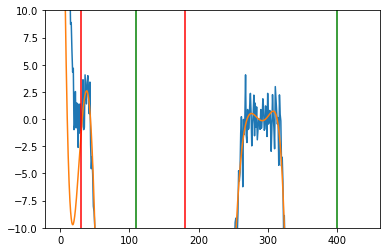

In [69]:
#checking for any diff from my code above:

#from erik
p2 = modeling.models.Polynomial1D(9,c0=1)#, n_models=1)


data = model_data4 
x_data = np.arange(len(data))
x_model = np.linspace(0, len(data), 10*len(data))

xfits = []
yfits = []
for lower, upper in skyaps:
    xfits.append(x_data[lower:upper])
    yfits.append(data[lower:upper])
xfit = np.concatenate(xfits)
yfit = np.concatenate(yfits)
new_model = pfit(p2, xfit.astype(float), yfit)

plt.plot(x_data, data) # should be the same as plt.plot(data)
plt.plot(x_model, new_model(x_model))
plt.ylim(-10,10)
new_model
for lower,upper in skyaps:
    plt.axvline(lower,color='r')
    plt.axvline(upper,color='g')

# doing sky subtract & extract spec in 2 steps instead of 1

In [70]:
#from reduce_dblspec
def subtract_sky(self, skyapertures, skymodel=None):
        """
        Subtracts sky from the 2D image along the given apertures.

        Note that this currently assumes fitted sky has no uncertainty, which is
        probably only true with large enough sky apertures

        Parameters
        ----------
        skyapertures : list of 2-tuples or slice objects
            A list of 2-tuples (lower, upper) or slices, specifying the
            sections along the spatial direction to define the sky.
        skymodel : astropy.modeling.model
            The model to fit, or None to just subtract the mean

        Returns
        -------
        newimg : DoubleSpecImage
            A new 2D image with the sky subtracted
        fittedmodels : None or list of models
            The models fit along the row, or None if `skymodel` is None
        """
        from astropy import modeling

        apslcs = []
        for ap in skyapertures:
            if isinstance(ap, slice):
                apslcs.append(ap)
            else:
                apslcs.append(slice(*ap))

        if self.side == 'red':
            d = self.data.T  # first axis should be dispersion
        elif self.side == 'blue':
            d = self.data
        else:
            raise ValueError("unrecognized side " + str(self.side))

        subeds = []
        if skymodel:
            xs = np.arange(d.shape[1])
            xaps = np.concatenate([xs[ap] for ap in apslcs])

            if isinstance(skymodel, modeling.models.Linear1D):
                fitter = _linfit
            else:
                fitter = modeling.fitting.LevMarLSQFitter()#NonLinearLSQFitter()

            fitmodels = []
            for cut in d:
                yaps = np.concatenate([cut[ap] for ap in apslcs])
                fitmodels.append(fitter(skymodel, xaps, yaps))
                y = yaps
                subeds.append(cut - fitmodels[-1](xs))
        else:
            fitmodels = None
            for cut in d:
                yaps = np.concatenate([cut[ap] for ap in apslcs])
                subeds.append(cut - np.mean(yaps))

        # get the right spatial/dispersion axis convention
        if self.side == 'red':
            newdata = np.array(subeds).T
        elif self.side == 'blue':
            newdata = np.array(subeds)
        else:
            raise ValueError('unrecognized side '+str(self.side))

        res = DoubleSpecImage(newdata, self.unc, self.header,
                              self.side)
        pd = list(self.processingdone)
        pd.append('sky sub')
        res.processingdone = tuple(pd)

        return res, fitmodels

In [71]:
def extract_spectrum(self, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way

        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis

        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)

        if self.side == 'red':
            d = self.data
        elif self.side == 'blue':
            d = self.data.T
        else:
            raise ValueError('unrecognized side ' + str(self.side))

        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5

        return spec, unc